In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from prettytable import PrettyTable

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [52]:
def sample_weight(kappa, dim):
    kappa = torch.tensor(kappa, dtype=torch.float32)
    dim = torch.tensor(dim, dtype=torch.float32)
    b = dim / (torch.sqrt(torch.tensor(4.0) * kappa**2 + dim**2) + 2 * kappa)
    x = (1 - b) / (1 + b)
    c = kappa * x + dim * torch.log(1 - x**2)
    while True:
        z = torch.distributions.beta.Beta((dim - 1) / 2, (dim - 1) / 2).sample()
        w = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        u = torch.rand(1)
        if kappa * w + dim * torch.log(1 - x * w) - c >= torch.log(u):
            return w

def get_orthonormal_basis(mu):
    if torch.allclose(mu, torch.tensor([1.0, 0.0, 0.0])):
        return torch.eye(3)
    else:
        v = torch.tensor([1.0, 0.0, 0.0]) - torch.dot(mu, torch.tensor([1.0, 0.0, 0.0])) * mu
        v = v / v.norm(p=2)
        w = torch.cross(mu, v)
        return torch.stack([mu, v, w])

def sample_vmf(mu, kappa, num_samples):
    mu = torch.tensor(mu, dtype=torch.float32)
    dim = mu.size(0)
    mu = mu / mu.norm(p=2)
    result = torch.zeros(num_samples, dim)
    for n in range(num_samples):
        w = sample_weight(kappa, dim)
        v = torch.randn(dim - 1)
        v = v / v.norm(p=2)
        result[n, :] = torch.cat([torch.tensor([w]), torch.sqrt(1 - w**2) * v])
    U = get_orthonormal_basis(mu)
    return result @ U.T

def sp(x):
    d = x.shape[-1] - 1
    numerator = x[..., :d]
    denominator = 1 - x[..., d]
    near_pole = np.isclose(denominator, 0)
    projection = np.full_like(x[..., :d], np.inf) 
    projection[~near_pole] = numerator[~near_pole] / denominator[~near_pole, np.newaxis]
    return torch.tensor(projection)

def rand_projections(dim, n_projs=1000):
    projs = torch.randn(n_projs, dim)
    return projs / torch.norm(projs, p=2, dim=1, keepdim=True)

class Net(nn.Module):
    def __init__(self, size):
        super(Net, self).__init__()
        self.size = size
        self.net = nn.Sequential(nn.Linear(self.size, self.size))
    def forward(self, x):
        xhat = self.net(x)
        # xhat_t = torch.log(torch.norm(xhat, dim=1, keepdim=True))
        # return torch.cat((x, xhat_t), dim=1)
        return torch.cat((x,xhat),dim=-1)
    
def aswd(s1, s2, n_projs, phi, phi_optimizer, p=2, n_iters=100, lam=20, device=device):
    s1 = s1.detach()
    s2 = s2.detach()
    eps=1e-8

    for _ in range(n_iters):
        s1_t, s2_t = phi(s1), phi(s2)
        reg = lam * (s1_t.norm(p=2, dim=1) + s2_t.norm(p=2, dim=1)).mean()
        projs = rand_projections(s1_t.shape[-1], n_projs).to(device)
        
        p1, p2 = s1_t @ projs.T, s2_t @ projs.T
        wasserstein = torch.abs(torch.sort(p1.T, dim=1).values - torch.sort(p2.T, dim=1).values)
        wasserstein = (wasserstein.pow(p).sum(dim=1) * 512 / s1.shape[0] + eps).pow(1. / p).mean()
        
        loss = reg - wasserstein
        phi_optimizer.zero_grad()
        loss.backward(retain_graph=True)
        phi_optimizer.step()

    s1_t, s2_t = phi(s1), phi(s2)
    projs = rand_projections(s1_t.shape[-1], n_projs).to(device)
    p1, p2 = s1_t @ projs.T, s2_t @ projs.T
    wasserstein = torch.abs(torch.sort(p1.T, dim=1).values - torch.sort(p2.T, dim=1).values)
    wasserstein = wasserstein.pow(p).sum(dim=1).pow(1. / p).mean()

    return wasserstein

def compute_s3wd(s1, s2, phi=None, n_projs=1000, p=2, lam=0.2, n_iters=1000, device=device):
    p1 = sp(s1).to(device)
    p2 = sp(s2).to(device)
    
    if phi is None:
        phi = Net(p1.size(1)).to(device)
        phi_optimizer = optim.Adam(phi.parameters(), lr=5e-3, betas=(0.999, 0.999))
        d = aswd(p1, p2, n_projs, phi, phi_optimizer, p, n_iters, lam, device=device)
    else:
        p1_t, p2_t = phi(p1), phi(p2)
        projs = rand_projections(p1_t.shape[-1], n_projs).to(device)
        p1_proj, p2_proj = p1_t @ projs.T, p2_t @ projs.T
        wasserstein = torch.abs(torch.sort(p1_proj.T, dim=1).values - torch.sort(p2_proj.T, dim=1).values)
        d = wasserstein.pow(p).sum(dim=1).pow(1. / p).mean()
    
    return d

def plot_stuff(s1, s2, proj1, proj2, n_meridians=20, n_parallels=20, zoom_xlim=None, zoom_ylim=None):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(s1[:, 0], s1[:, 1], s1[:, 2], color='cyan', label='vMF 1', s=5)
    ax1.scatter(s2[:, 0], s2[:, 1], s2[:, 2], color='red', label='vMF 2', s=5)
    ax1.scatter(0, 0, 1, color='blue', label='North Pole', s=50)  
    ax1.scatter(0, 0, -1, color='blue', label='South Pole', s=50)
    ax1.set_box_aspect([1,1,1])
    ax2 = fig.add_subplot(122)
    u = np.linspace(0, 2 * np.pi, 200)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    meridian_step = x.shape[0] // n_meridians
    parallel_indices = np.round(np.linspace(0, y.shape[1] - 1, n_parallels)).astype(int)

    for i in range(0, x.shape[0], meridian_step):
        ax1.plot(x[i], y[i], z[i], color='gray', alpha=0.1)
        grid_points = np.stack((x[i], y[i], z[i]), axis=-1)
        projected_grid = sp(grid_points)
        ax2.plot(projected_grid[:, 0], projected_grid[:, 1], color='gray', alpha=0.1)

    for j in parallel_indices:
        ax1.plot(x[:, j], y[:, j], z[:, j], color='gray', alpha=0.1)
        grid_points = np.stack((x[:, j], y[:, j], z[:, j]), axis=-1)
        projected_grid = sp(grid_points)
        ax2.plot(projected_grid[:, 0], projected_grid[:, 1], color='gray', alpha=0.1)


    ax2.scatter(proj1[:, 0], proj1[:, 1], color='cyan', s=5)
    ax2.scatter(proj2[:, 0], proj2[:, 1], color='red', s=5)

    if zoom_xlim is not None:
        ax2.set_xlim(zoom_xlim)
    if zoom_ylim is not None:
        ax2.set_ylim(zoom_ylim)
        
    plt.show()

In [53]:
mu1 = np.array([0, 0, 1])
mu2 = np.array([1,0,-1])
kappa = 1000
N = 1000
s1 = sample_vmf(mu1, kappa, N)
s2 = sample_vmf(mu2, kappa, N)

tensor(5.7429, device='cuda:0', grad_fn=<MeanBackward0>)


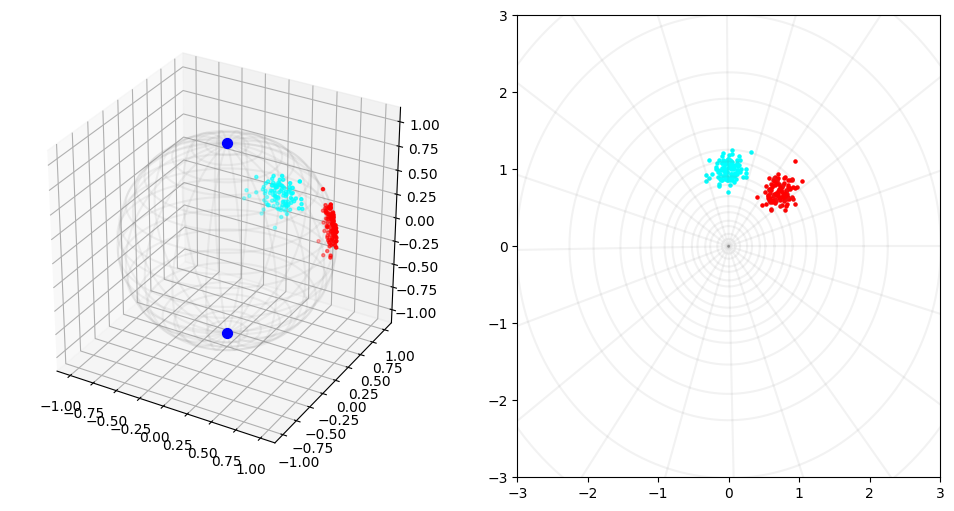

In [81]:
s3w = compute_s3wd(s1, s2, phi=None, n_projs=2000, p=2, lam=0, n_iters=100, device=device)
print(s3w)
ps1 = sp(s1)
ps2 = sp(s2)

plot_stuff(s1,s2,ps1,ps2,zoom_xlim=(-3, 3), zoom_ylim=(-3, 3))

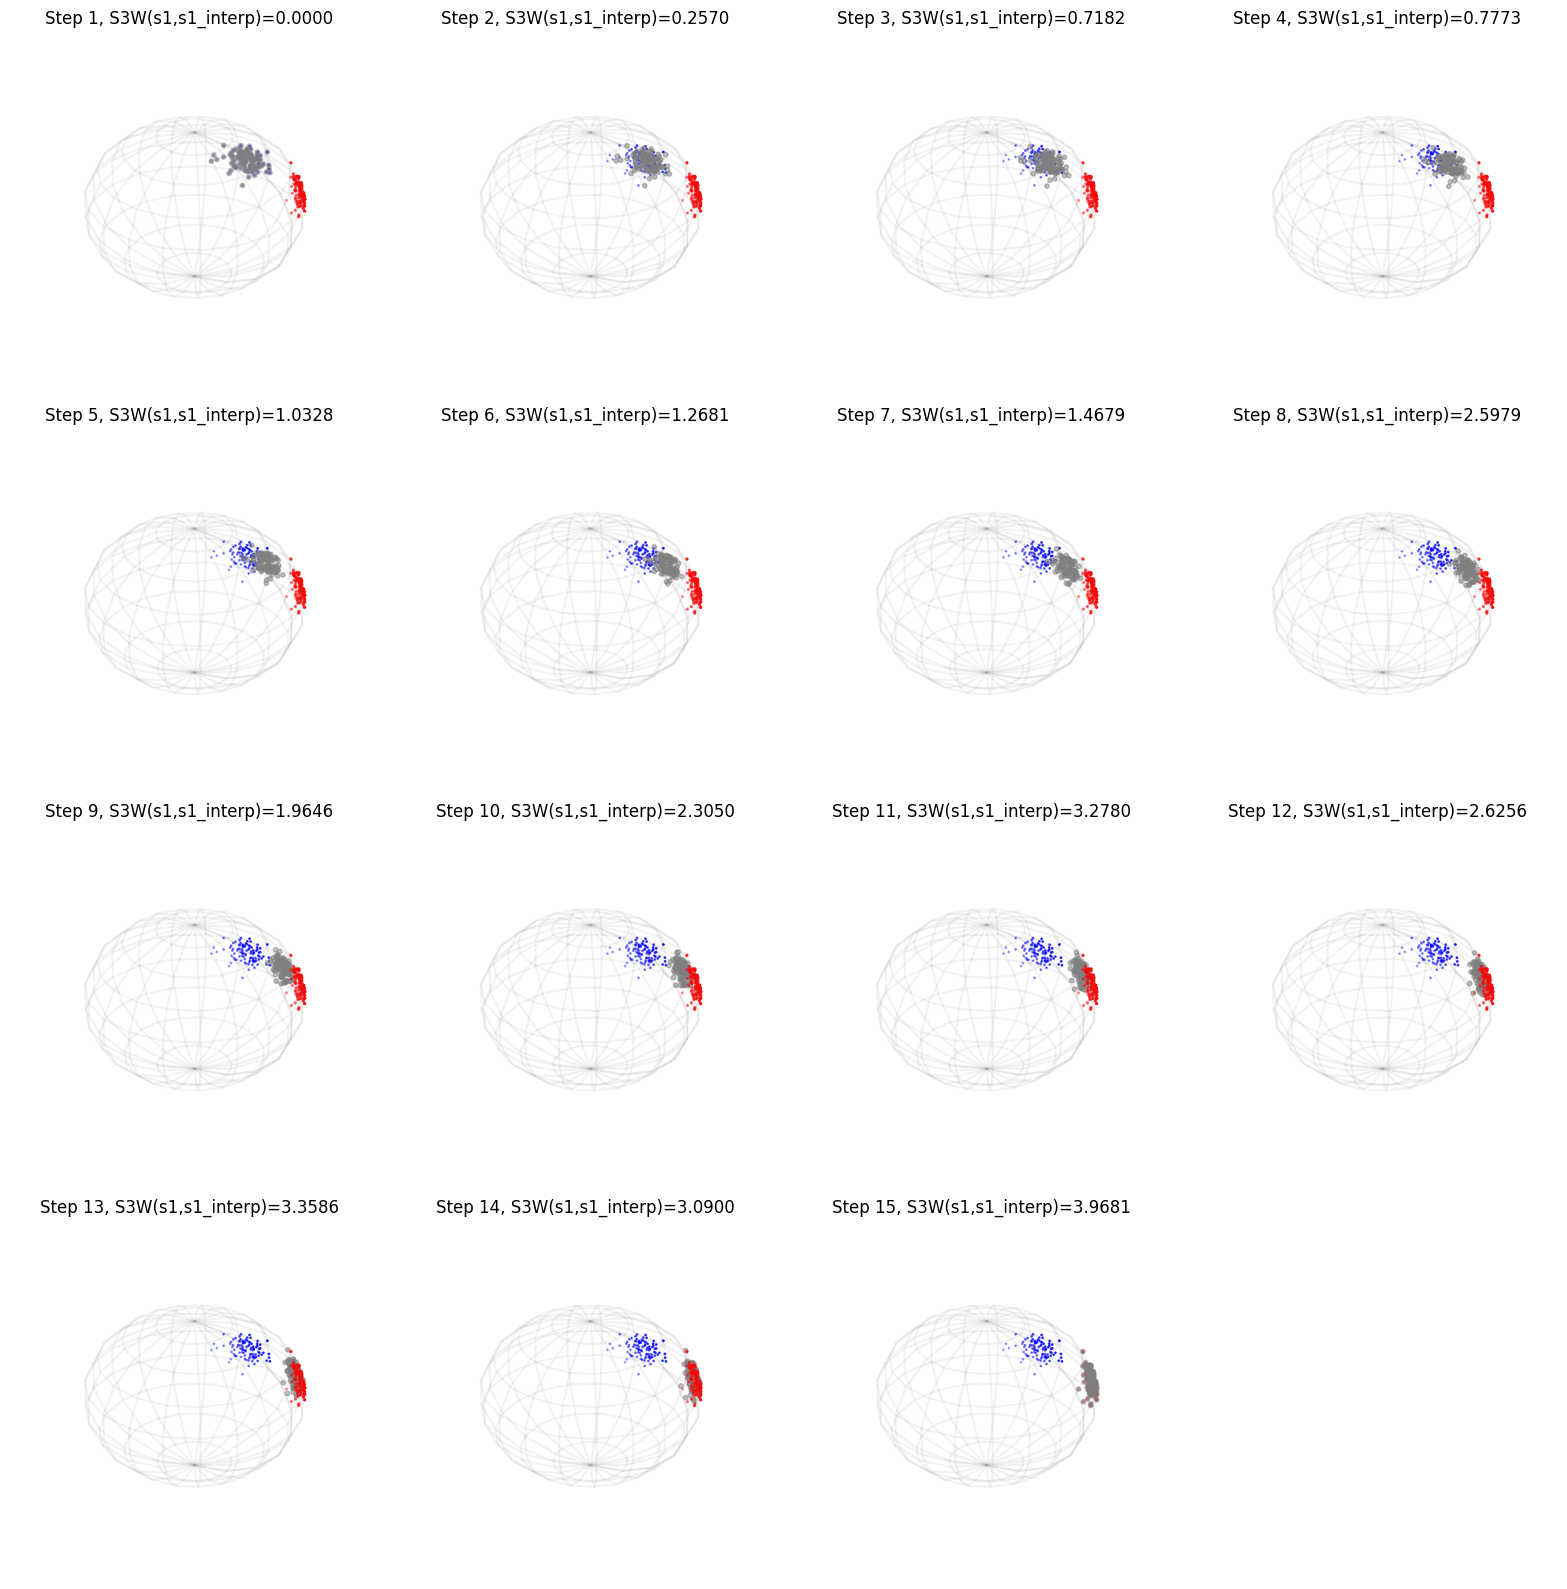

In [59]:
def slerp(s1, s2, t):
    omegas = torch.acos(torch.clamp(torch.sum(s1 * s2, dim=1), -1, 1))
    sos = torch.sin(omegas)
    return torch.sin((1.0 - t) * omegas).unsqueeze(-1) / sos.unsqueeze(-1) * s1 + torch.sin(t * omegas).unsqueeze(-1) / sos.unsqueeze(-1) * s2

def plot_sphere(ax):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.1)

mu1 = np.array([0, 0, 1])
mu2 = np.array([1, 0, -1])
kappa = 100
N = 100 

s1 = sample_vmf(mu1, kappa, N).clone().detach()
s2 = sample_vmf(mu2, kappa, N).clone().detach()

n_steps = 15
rows = int(np.ceil(n_steps / 4))
fig = plt.figure(figsize=(4 * 4, 4 * rows))

for i in range(n_steps):
    ax = fig.add_subplot(rows, 4, i + 1, projection='3d')
    t = i / (n_steps - 1)
    s_interp = slerp(s1, s2, t)

    s3w = compute_s3wd(s1, s_interp, phi=None, n_projs=2000, p=2, lam=500, n_iters=100, device='cuda:0')

    plot_sphere(ax)
    ax.scatter(s1[:, 0], s1[:, 1], s1[:, 2], color='blue', label='s1',s=1)
    ax.scatter(s2[:, 0], s2[:, 1], s2[:, 2], color='red', label='s2',s=2)
    ax.scatter(s_interp[:, 0], s_interp[:, 1], s_interp[:, 2], color='gray',s=10, alpha=0.5, label='interp')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.axis('off')
    ax.set_title(f'Step {i+1}, S3W(s1,s1_interp)={s3w.item():.4f}')

plt.tight_layout()
plt.show()

In [6]:
# def eval_s3wd(s1, s2, max_iters, nprojs, lam, p, device='cuda'):
#     results = []
#     for iters, n_proj, l, pow in product(max_iters, nprojs, lam, p):
#         distances = []
#         for _ in range(10):  # Run each combination 10 times
#             d = compute_s3wd(s1, s2, n_projs=n_proj, p=pow, lam=l, n_iters=iters, device=device)
#             distances.append(d.item())

#         mean_d = np.mean(distances)
#         var_d = np.var(distances)
#         results.append({'iters': iters, 'n_proj': n_proj, 'lam': l, 'p': pow, 'mean_d': mean_d, 'var_d': var_d})

#     return results

# def print_results(results):
#     table = PrettyTable()
#     table.field_names = ['max iters', 'n projs', 'lambda', 'p', 'mean', 'var']
#     for res in results:
#         table.add_row([res['iters'], res['n_proj'], res['lam'], res['p'], res['mean_d'], res['var_d']])
#     print(table)


In [7]:
# max_iters = [10, 20, 50, 100, 500, 1000, 2000]
# nprojs = [1000, 2000]
# lam = [0, 1, 10, 100, 500, 1000, 10000, 100000]
# p = [1, 2]

# Hyperparams

### Max Iterations (max_iters):

- Mean Distance: stable across different iteration counts
- Variance: decreasing trend as iterations increases
### Number of Projections (n_projs):

- Mean Distance: fluctuates
- Variance: fluctuates
### Lambda (lambda):

- Mean Distance: increases with higher lambdas
- Variance: general decreasing trend with increasing lambda
### P (p):

- Mean Distance: appears to be higher for p=2 compared to p=1
- Variance: generally higher for p=1 than for p=2

In [352]:
results = eval_s3wd(s1, s2, max_iters, nprojs, lam, p, device='cuda')
print_results(results)

+-----------+---------+--------+---+--------------------+-----------------------+
| max iters | n projs | lambda | p |        mean        |          var          |
+-----------+---------+--------+---+--------------------+-----------------------+
|     10    |   1000  |   0    | 1 | 35.680059814453124 |   7.407620012437691   |
|     10    |   1000  |   0    | 2 | 3.788795304298401  |  0.06160118741315784  |
|     10    |   1000  |   1    | 1 | 39.101966857910156 |   12.777201296968268  |
|     10    |   1000  |   1    | 2 | 3.733320927619934  |   0.0526799166556026  |
|     10    |   1000  |   10   | 1 | 36.65481414794922  |   9.122301193481544   |
|     10    |   1000  |   10   | 2 | 3.5951013803482055 |  0.17470380583678718  |
|     10    |   1000  |  100   | 1 | 38.10977439880371  |   9.101562470573263   |
|     10    |   1000  |  100   | 2 | 3.529991865158081  |  0.10707372665998491  |
|     10    |   1000  |  500   | 1 | 35.86977005004883  |    8.59005208806484   |
|     10    |   